In [1]:
import numpy as np
import pandas as pd
from collections import deque, defaultdict
import ast
import os
import glob
from pathlib import Path
from scipy.stats import mode
from modeling_parameters.config import (
    MATPLOTLIBRC_PATH,
    COORDINATES_PATH,
)

import matplotlib as mpl
mpl.rc_file(MATPLOTLIBRC_PATH)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns

from functions import (
    add_distance_to_df,
    is_central_stations,
)

In [2]:
events_df = pd.read_parquet('../events.parquet', engine='pyarrow')

In [3]:
decor_dot = (0, 0, -8)
x_d, y_d, z_d = decor_dot
events_df = add_distance_to_df(events_df, decor_dot)

In [4]:
events_df['rho_mu'] = events_df['Nview'] / events_df['Sdet']

In [5]:
events_df.head(3)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,...,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std,Sdet,r_decor,rho_mu
0,836,6627,63.67,116.71,33.168543,-80.000,5468.278104,1.441416,0.633660,6,...,7,"[2, 3, 4, 5, 6, 7, 8]","[False, False, False, False, True, True, False...","[0.5754942602040817, 0.22737962372448978, 0.39...","[None, None, None, None, 143.637, 88.789, None...","[None, None, None, None, 86.628, 34.227, None,...","[None, None, None, None, 2353.241, 2339.532, N...",28.4839,45.917690,0.245753
1,836,12188,42.90,198.78,50.000000,80.000,90724.620406,2.000000,0.496810,17,...,15,"[3, 4, 5, 7, 9]","[False, False, False, False, False, False, Fal...","[0.30331898384353745, 0.4862218324829932, 0.03...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",26.5495,83.887920,0.564982
2,836,12453,51.32,212.71,-25.359000,5.885,15917.649306,1.961136,0.749836,6,...,6,"[1, 2, 3, 5, 8]","[True, True, True, True, True, True, True, Tru...","[0.9574829931972789, 0.171343537414966, 0.1644...","[247.509, 76.928, 85.595, 53.739, 21.248, 89.5...","[144.128, 25.792, 24.751, 20.768, 7.834, 42.13...","[2376.449, 2347.995, 2335.962, 2361.802, 2372....",30.8412,19.340653,0.194545


In [6]:
n = 2
events_df = events_df[events_df.apply(lambda row: is_central_stations(row, n), axis=1)]

In [9]:
events_df = events_df[
    (events_df['X0_opt'] > -20) & (events_df['X0_opt'] < 20) &
    (events_df['Y0_opt'] > -40) & (events_df['Y0_opt'] < 40) &
    (events_df['loss'] < 1) &
    (events_df['s_opt'] < 1.9) & (events_df['s_opt'] > 1.2)   
]

In [10]:
rho_mu = np.array(events_df['rho_mu'])
r_decor = np.array(events_df['r_decor'])


In [11]:
muon_df = pd.read_csv('rho_mu_corsika/pDAT165008r_rho_m.txt', sep='\t', header=None)
muon_df.columns = ['r', 'rho', 's']

r = np.array(10 ** muon_df['r'])
rho = np.array(muon_df['rho'])

mask = rho > 0
r = r[mask]
rho = rho[mask]


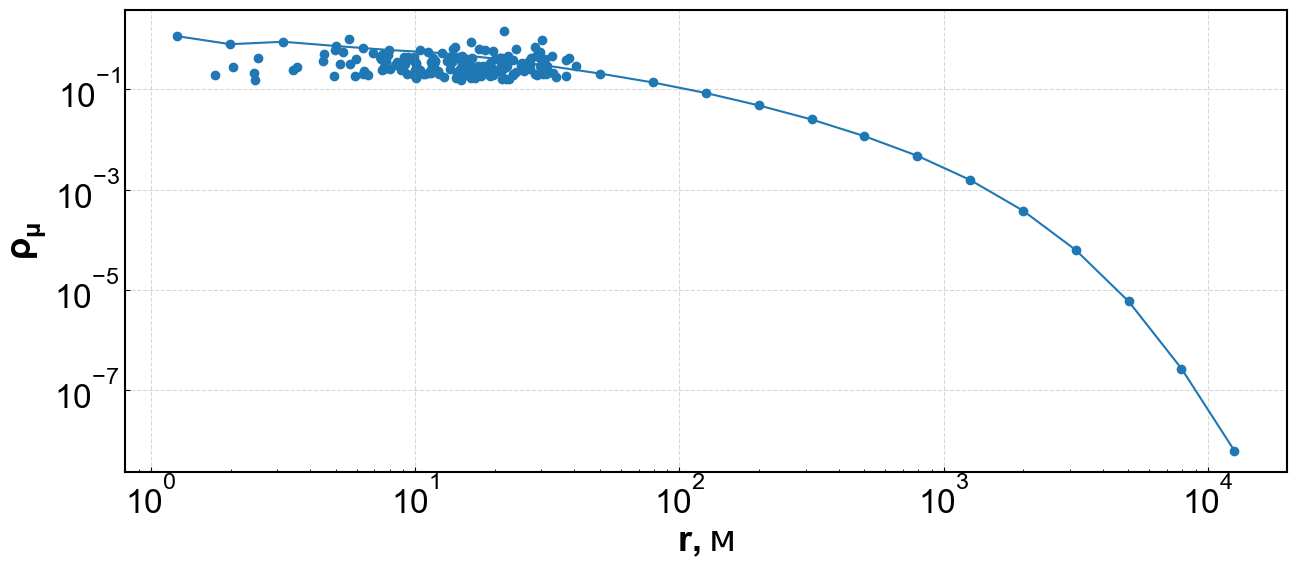

In [12]:
plt.figure(figsize=(15, 6))

plt.plot(r, rho, marker='o')
plt.scatter(r_decor, rho_mu, marker='o')

plt.xlabel(r'$r,\text{м}$')
plt.ylabel(r'$\rho_{\mu}$')
plt.yscale('log')
plt.xscale('log')

plt.grid()
plt.show()